<a href="https://colab.research.google.com/github/RealMyeong/Going_Deeper_NLP/blob/main/Transformer_%ED%95%9C%EC%98%81%EB%B2%88%EC%97%AD%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 데이터 불러온 후 정제 및 토큰화

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,183 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)
import time
import re
import os

In [3]:

kor_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/8_한영번역기/korean-english-park.train/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/AIFFEL/GoingDeeper_NLP/8_한영번역기/korean-english-park.train/korean-english-park.train.en'

# 중복된 데이터 삭제

def clean_corpus(kor_path, eng_path):
  with open(kor_path, 'r') as f:
    kor = f.read().splitlines()
  with open(eng_path, 'r') as f:
    eng = f.read().splitlines()
  assert len(kor) == len(eng)

  sen_zip = zip(kor, eng)
  sen_zip = set(sen_zip)
  n_dup_ko, n_dup_eng = zip(*sen_zip)

  return n_dup_ko, n_dup_eng

cleaned_ko, cleaned_eng = clean_corpus(kor_path, eng_path)



In [4]:
print(len(cleaned_ko))
cleaned_ko[:5]

78968


('미 캘리포니아 남부 산불로 14명이 사망하고 50만8000에이커가 불에 탔으며 1600채의 가옥이 전소됐다.',
 '최초의 폭발은 아침 10시경 유명 식당에서 있었고 두 번째 폭발은 10분 뒤 100야드 떨어진 지점의 알 수타 알 라베이아 지구의 시장거리에서 발생했다.',
 '미국 남부로 조지아주 토속 음식 여행을 떠나보자.',
 '특히 대졸이나 고등교육을 받은 전문직과 기술직의 부족은 각각 7,300명과 17,000명에 이른다고 한다.',
 '이에앞서 미국반도핑기구(USADA)는 53페이지의 조항을 들어 게이틀린에게 출전정지 4년의 중징계를 내렸다.')

In [5]:
print(len(cleaned_eng))
cleaned_eng[:5]

78968


('The fires are blamed for 14 deaths and charred more than 508,000 acres, destroying about 1,600 homes.',
 'The first bomb hit a popular restaurant at about 10 a.m., while a second one exploded 10 minutes later and 100 yards away in an outdoor market in al-Shurta al-Rabeia district, police said.',
 "T+L heads south to get a taste of some of Georgia's best homegrown talent.",
 'In particular, the lack of professionals and technicians with undergraduate or higher-level educations stood at 7,300 and 17,000, respectively.',
 "A three-member arbitration panel cut Gatlin's suspension in half to four years in a 53-page ruling released Tuesday.")

- 간단한 전처리 함수 정의
  - 모든 입력 소문자로 변환
  - 알파벳, 문장부호, 한글만 남기고 제거
  - 문장부호 양 옆에 공백 추가
  - 문장 앞뒤의 불필요한 공백 제거

In [6]:
import re

def preprocess_sentence(sentence, s_token=False, e_token=False, ko=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^0-9a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ?.!,]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [7]:
cleaned_ko = [preprocess_sentence(x, ko=True) for x in cleaned_ko]
cleaned_eng = [preprocess_sentence(x) for x in cleaned_eng]

In [8]:
cleaned_ko[:5]

['미 캘리포니아 남부 산불로 14명이 사망하고 50만8000에이커가 불에 탔으며 1600채의 가옥이 전소됐다 .',
 '최초의 폭발은 아침 10시경 유명 식당에서 있었고 두 번째 폭발은 10분 뒤 100야드 떨어진 지점의 알 수타 알 라베이아 지구의 시장거리에서 발생했다 .',
 '미국 남부로 조지아주 토속 음식 여행을 떠나보자 .',
 '특히 대졸이나 고등교육을 받은 전문직과 기술직의 부족은 각각 7 , 300명과 17 , 000명에 이른다고 한다 .',
 '이에앞서 미국반도핑기구 usada 는 53페이지의 조항을 들어 게이틀린에게 출전정지 4년의 중징계를 내렸다 .']

In [9]:
cleaned_eng[:5]

['the fires are blamed for 14 deaths and charred more than 508 , 000 acres , destroying about 1 , 600 homes .',
 'the first bomb hit a popular restaurant at about 10 a . m . , while a second one exploded 10 minutes later and 100 yards away in an outdoor market in al shurta al rabeia district , police said .',
 't l heads south to get a taste of some of georgia s best homegrown talent .',
 'in particular , the lack of professionals and technicians with undergraduate or higher level educations stood at 7 , 300 and 17 , 000 , respectively .',
 'a three member arbitration panel cut gatlin s suspension in half to four years in a 53 page ruling released tuesday .']

- SentencePiece로 토큰화하기

In [10]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.2 MB/s 


In [11]:
import sentencepiece as spm

In [12]:
import os
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, model_type='unigram', vocab_size=32000, lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [13]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

ko_tokenizer = generate_tokenizer(cleaned_ko, 'bpe', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(cleaned_eng, 'bpe', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [14]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [15]:
ko_test_txts = ['한편 이번 금융사고는 개인이 저지른 것 중 규모가 가장 클 뿐만아니라 유럽에서 발생한 금융사기 중 최대 규모이다.']
en_test_txts = ['Polanski failed to show up for sentencing and never returned to the United States.']

In [16]:
testSP(ko_tokenizer, ko_test_txts)


[['▁한편',
  '▁이번',
  '▁금융',
  '사고는',
  '▁개인이',
  '▁저지른',
  '▁것',
  '▁중',
  '▁규모가',
  '▁가장',
  '▁클',
  '▁뿐만아니라',
  '▁유럽에서',
  '▁발생한',
  '▁금융',
  '사기',
  '▁중',
  '▁최대',
  '▁규모',
  '이다',
  '.']]

In [17]:
testSP(en_tokenizer, en_test_txts)


[['<s>',
  '▁',
  'P',
  'ol',
  'anski',
  '▁failed',
  '▁to',
  '▁show',
  '▁up',
  '▁for',
  '▁sentencing',
  '▁and',
  '▁never',
  '▁returned',
  '▁to',
  '▁the',
  '▁',
  'U',
  'n',
  'ited',
  '▁',
  'S',
  't',
  'ates',
  '.',
  '</s>']]

In [18]:
src_corpus = []
tgt_corpus = []

assert len(cleaned_ko) == len(cleaned_eng)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in (range(len(cleaned_ko))):
    src = ko_tokenizer.EncodeAsIds(cleaned_ko[idx])
    tgt = en_tokenizer.EncodeAsIds(cleaned_eng[idx])
    
    if 5<= len(src) <= 60 and 5<= len(tgt) <= 60:
        src_corpus.append(src)
        tgt_corpus.append(tgt)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

In [19]:
print(enc_train.shape)
enc_train[1]

(77089, 60)


array([ 2920, 13091,  1570,   215, 11093,  1201, 15648,  5100,   231,
        1407, 13091,   215, 30981,   420,   989, 13242,  1170,  9298,
       30815,    98,    18, 30950,    98,   186,  1385, 30842,  9991,
        1700, 30931,  1447,  1497,     4,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [20]:
print(dec_train.shape)
dec_train[1]

(77089, 60)


array([    1,     9,   367,   907,  1243,     5,  2329,  5652,    97,
         253,   663,     5,    15,    26,    15,    16,   648,     5,
         769,   291,  4545,   663,  1835,  1112,    45,  1277,  9138,
        1439,    29,    36, 10706,   869,    29,   103,   142,    71,
        1824,   103, 31021,   202,  2252,    16,   358,    77,    15,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

- 모델 설계

In [21]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*int(i)) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    # 짝수 인덱스에는 sin함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 홀수 인덱스에는 cos함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # 나눌 헤드의 개수
        self.num_heads = num_heads
        self.d_model = d_model
        # 헤드 당 차원의 크기
        self.depth = d_model // self.num_heads
        # Q, K, V 가중치
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # Q K^T 계산

        QK = tf.matmul(Q, K, transpose_b=True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        # x.shape = (batch_size, length, d_model)
        batch_size = x.shape[0]
        # split_x.shape = (batch_size, length, heads, (d_model / n_heads))
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # 각 배치에 각 헤드당 (length X depth)가 있음.
                                                           # (batch_size, heads, length, depth)

        return split_x

    def combine_heads(self, x):
        # x.shape = (batch_size, heads, length, depth)
        batch_size = x.shape[0]
        # (batch_size, length, heads, depth)로 바꿔줌
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        # (batch_size, length, heads X depth)로 최종 변환 -> concat한 것.
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        # Q, K, V각각 linear transformation함.
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # 각각을 헤드 개수만큼 나눠줌 
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    		
        out = self.combine_heads(out)
        # 이 부분이 concat(head_1, ..., head_n) x WO 부분임.
        out = self.linear(out)
                
        return out, attention_weights

In [23]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


In [24]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        # Multi-Head Attention 계산
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        # residual connection 
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # 인코더의 output과 디코더 output을 입력으로 넣어주는 부분.
        # 마스킹을 통하여 leftward information flow를 유지해줌
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers, # 인코더 레이어의 개수
                 d_model, # input 차원
                 n_heads, # 헤드 몇개로 나눌것인지
                 d_ff, # feed forward net의 히든레이어 차원
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.1,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)
        # [length x d_model]로 된 positional_encoding의 반환값을
        # np.newaxis를 통해 [1 x length x d_model]로 바꿔줌 -> 브로드캐스팅을 가능하게 하기위해
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [29]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [30]:
transformer = Transformer(
    n_layers=4,
    d_model=512,
    n_heads=8,
    d_ff = 2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [34]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [35]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [36]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [37]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [38]:
from tqdm import tqdm
import random

BATCH_SIZE = 64
EPOCHS = 15

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "넌 젖을수록 투명해지는 꽃"      
]

# loss 시각화를 위해 값을 저장할 리스트 생성
loss_=[]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    
    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)
        
        loss_.append(batch_loss)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

Epoch  1: 100%|██████████| 1205/1205 [08:07<00:00,  2.47it/s, Loss 6.3225]


Input: 오바마는 대통령이다.
Predicted translation: obama s remarks .
Input: 시민들은 도시 속에 산다.
Predicted translation: the sun is a half of the sun .
Input: 커피는 필요 없다.
Predicted translation: we don t think that we ll be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast was killed in the city of the city of the city s death toll .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: the new york city is the first time .


Epoch  2: 100%|██████████| 1205/1205 [07:59<00:00,  2.51it/s, Loss 4.9086]


Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate for obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban urban .
Input: 커피는 필요 없다.
Predicted translation: it is not a good thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: cnn a suicide bomber died in a suicide bombing at least 20 people dead .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: it s a big thing for a good time , and it seems to go back to a new study .


Epoch  3: 100%|██████████| 1205/1205 [07:58<00:00,  2.52it/s, Loss 4.3042]


Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cities are a major night .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the attack .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: the couple s parents are increasingly increasingly increasingly increasingly important to get a chance to get a chance to find a chance to get a chance to get a chance to get a chance to get a chance to get a chance to get a chance to a relationship with a small relationship with a relationship with a relationship with


Epoch  4: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 3.8165]


Input: 오바마는 대통령이다.
Predicted translation: obama is a major problem .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cities of the city is a urban city .
Input: 커피는 필요 없다.
Predicted translation: no coffee is a good reason .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the  ⁇  . 9 magnitude quake struck .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: they say they were a particular relationship with a particular relationship .


Epoch  5: 100%|██████████| 1205/1205 [07:57<00:00,  2.53it/s, Loss 3.0383]


Input: 오바마는 대통령이다.
Predicted translation: obama is a new presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban city of urban areas
Input: 커피는 필요 없다.
Predicted translation: don t need to need anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: it s a simple thing that you want


Epoch  6: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 2.2336]


Input: 오바마는 대통령이다.
Predicted translation: obama is a leading presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban sanja san fighters .
Input: 커피는 필요 없다.
Predicted translation: the idea is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , it s a simple hour , like a simple hour search .


Epoch  7: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 1.5712]


Input: 오바마는 대통령이다.
Predicted translation: obama is a sign of the f 11 . 2 million .
Input: 시민들은 도시 속에 산다.
Predicted translation: the cities in the cities across the cities
Input: 커피는 필요 없다.
Predicted translation: for the common , the need for resolution .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died , and seven were wounded .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , and , they just want to learn more about the importance of looking for a generation of stay on sleep and sleep deprivation , says the relationship with a particular importance study .


Epoch  8: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 1.0858]


Input: 오바마는 대통령이다.
Predicted translation: obama is a leading presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: several of the cities around the world .
Input: 커피는 필요 없다.
Predicted translation: for the first half of the necessary democracy , the united states is illegal .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were injured .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , the friends of these were all unusual films , watching and transparency , watching and watching from all these activities .


Epoch  9: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 0.7846]


Input: 오바마는 대통령이다.
Predicted translation: obama is a candidate with the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: with the sun in the cities of the spring .
Input: 커피는 필요 없다.
Predicted translation: no coffee is a lohan who do not need to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were injured in the next day .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: he described the mehdi army as a oct .


Epoch 10: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 0.6027]


Input: 오바마는 대통령이다.
Predicted translation: obama is out for mccain .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the best of fire in the region .
Input: 커피는 필요 없다.
Predicted translation: needed all necessary testing is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the blast .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and as the friends do better .


Epoch 11: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 0.4961]


Input: 오바마는 대통령이다.
Predicted translation: obama is out of the presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: that handle the urban cities of the weekend .
Input: 커피는 필요 없다.
Predicted translation: needed to ensure that needed much needed based .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were wounded .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , it d better those images like a simple conversation


Epoch 12: 100%|██████████| 1205/1205 [07:58<00:00,  2.52it/s, Loss 0.4184]


Input: 오바마는 대통령이다.
Predicted translation: obama is out on the presidency during the presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: these san fantastic 199 ⁇  .
Input: 커피는 필요 없다.
Predicted translation: needed to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the blast .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , it s a kids that can be sleep .


Epoch 13: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 0.3639]


Input: 오바마는 대통령이다.
Predicted translation: obama is a front runner up .
Input: 시민들은 도시 속에 산다.
Predicted translation: with 10 , 000 people out of the cities .
Input: 커피는 필요 없다.
Predicted translation: for all you need in coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the blast .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: he d like a member of the axis of evil .


Epoch 14: 100%|██████████| 1205/1205 [07:57<00:00,  2.52it/s, Loss 0.3238]


Input: 오바마는 대통령이다.
Predicted translation: obama is ahead for obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: hundreds of people took out of the city .
Input: 커피는 필요 없다.
Predicted translation: needed half the rights to go ahead .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven others died in the blast .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and , the effort picture isn t all that actors and children all david improve the chances of touch .


Epoch 15: 100%|██████████| 1205/1205 [07:58<00:00,  2.52it/s, Loss 0.2896]


Input: 오바마는 대통령이다.
Predicted translation: obama is ahead of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they want to get out of this country .
Input: 커피는 필요 없다.
Predicted translation: needed to do your needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Input: 넌 젖을수록 투명해지는 꽃
Predicted translation: and the fact that the kids were born when they were born drunk to 41 percent of attack people .


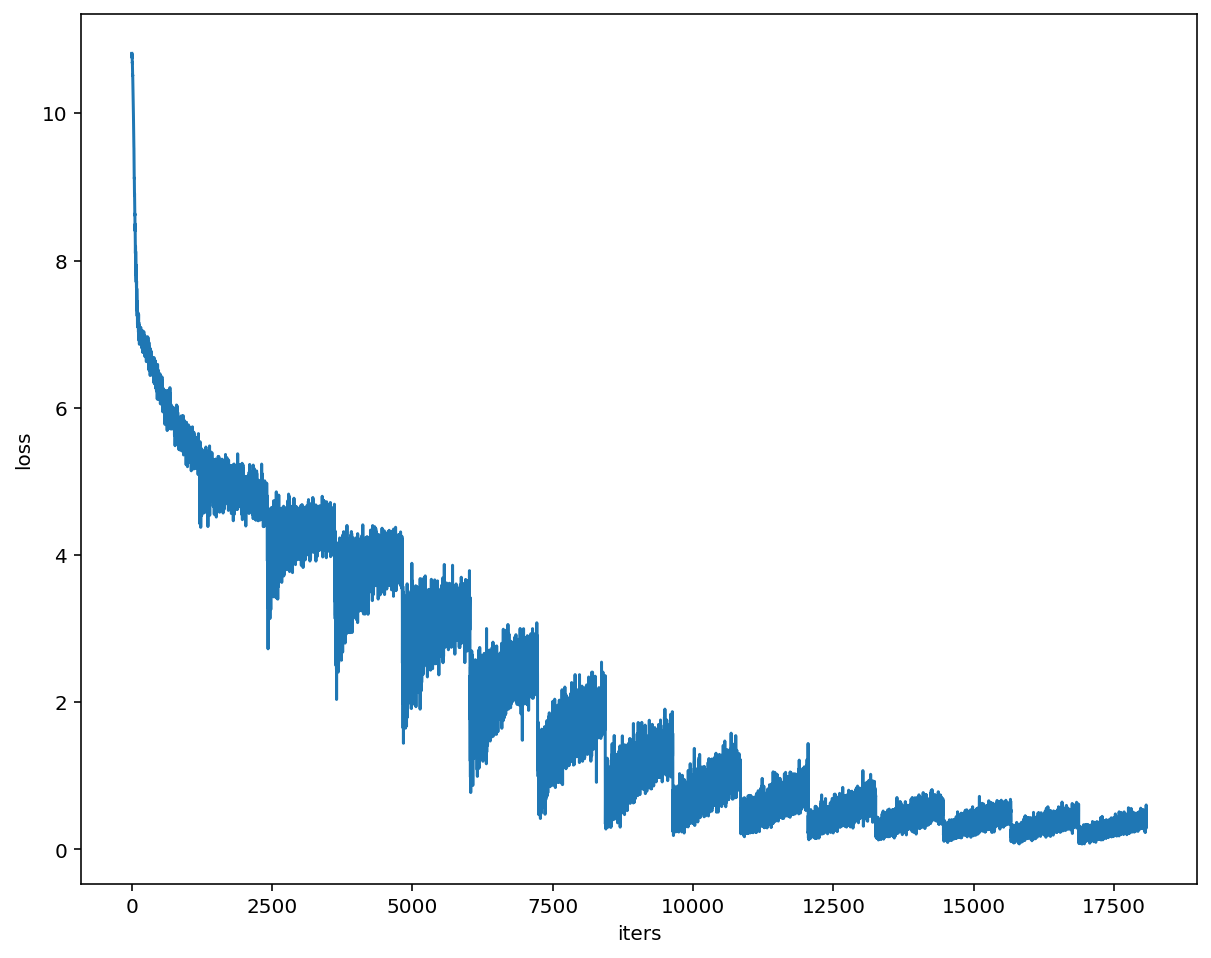

In [39]:
plt.figure(figsize=(10,8))
plt.plot(loss_)
plt.xlabel('iters')
plt.ylabel('loss')
plt.show()

- 실험 결과 비교

| | 1st | 2nd | 3rd | 4th|
|:---:|---|---|---|---|
|epoch|15|15 |15 |15 |
|batch_size|64 |64 |64 |64 |
|n_layer|4 |4 |4 |4 |
|d_model|512 |512 |512 |512 |
|d_ff|2048 |2048 |2048 |2048 |
|n_heads|8 |8 |8 |8 |
|pos_len|100 |100 |200 |200 |
|dropout|0.1 |0.1 |0.2 |0.2 |
|vocab_size|srs, tgt : 25000|srs, tgt : 25000 |srs, tgt : 25000 |srs, tgt : 32000 |
|preprocess|sentencepiece : 'unigram' \| toekn_restrict : 3$\leq$#token$\leq$50 |sentencepiece : 'bpe' \| toekn_restrict : 3$\leq$#token$\leq$60 |sentencepiece : 'unigram' \| toekn_restrict : 3$\leq$#token$\leq$60 |sentencepiece : 'unigram' \| toekn_restrict : 3$\leq$#token$\leq$60 |
|best translation|[Epoch 13:  Loss 0.3270]<br><br>Input: 오바마는 대통령이다.<br>Predicted translation: obama is the son of president .<br><br>Input: 시민들은 도시 속에 산다.<br>Predicted translation: some quick get in the city .<br><br>Input: 커피는 필요 없다.<br>Predicted translation: no one is coffee .<br><br>Input: 일곱 명의 사망자가 발생했다.<br>Predicted translation: seven other people died in the attack .<br><br>Input: 넌 젖을수록 투명해지는 꽃<br>Predicted translation: the equivalent of the horses , williams then turned out very cars with what s happening . |[Epoch  4: Loss 3.8017]<br><br>Input: 오바마는 대통령이다.<br>Predicted translation: obama is a leading presidential candidate .<br><br>Input: 시민들은 도시 속에 산다.<br>Predicted translation: the city s main city .<br><br>Input: 커피는 필요 없다.<br>Predicted translation: coffee is not allowed .<br><br>Input: 일곱 명의 사망자가 발생했다.<br>Predicted translation: seven people have died .<br><br>Input: 넌 젖을수록 투명해지는 꽃<br>Predicted translation: the paper said that snails and transparently . |[Epoch  6:  Loss 2.2295]<br><br>Input: 오바마는 대통령이다.<br>Predicted translation: obama is the democratic presidential candidate .<br><br>Input: 시민들은 도시 속에 산다.<br>Predicted translation: citizens are called in the city of commemorate the city .<br><br>Input: 커피는 필요 없다.<br>Predicted translation: you can t need for coffee .<br><br>Input: 일곱 명의 사망자가 발생했다.<br>Predicted translation: seven people died , the official said .<br><br>Input: 넌 젖을수록 투명해지는 꽃<br>Predicted translation: others have left more transparent and have caused serious tumor . |[Epoch 15:  Loss 0.2896]<br><br>Input: 오바마는 대통령이다.<br>Predicted translation: obama is ahead of the president .<br><br>Input: 시민들은 도시 속에 산다.<br>Predicted translation: they want to get out of this country .<br><br>Input: 커피는 필요 없다.<br>Predicted translation: needed to do your needed .<br><br>Input: 일곱 명의 사망자가 발생했다.<br>Predicted translation: seven people were killed .<br><br>Input: 넌 젖을수록 투명해지는 꽃<br>Predicted translation: and the fact that the kids were born when they were born drunk to 41 percent of attack people . |
|평가|어느정도 중요한 단어는 포함하고 있지만 의미가 맞는 문장이 그닥 없음 | 전보다 훨씬 의미적으로 쓸만한 문장들이 나옴|마지막 문장은 훈련 데이터에 관련 단어나 내용이 너무 없어서 그런지는 몰라도 번역을 너무 못하는 모습을 보임. |어째 단어장 크기를 늘리니까 더 이상해지는 것 같기도….허허 |